# Data analysis books for YouBike services
We require to install **pandas**, **metplotlib** and **seaborn** in the virtual environment. 


In [2]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt

pd.set_option('display.max_rows',5)
pd.set_option('large_repr', 'info')

li = []
for dirname, _, filenames in os.walk('./data/'):
    for filename in filenames:
        df = pd.read_csv(dirname+filename, index_col=None, header=0)
        li.append(df)
# read data here
bikecsv = pd.concat(li, axis=0, ignore_index=True)

bikecsv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   _id              814262 non-null  object
 1   station_no       814262 non-null  int64 
 2   station_name     814262 non-null  object
 3   station_name_en  814262 non-null  object
 4   district         814262 non-null  object
 5   district_en      814262 non-null  object
 6   total            814262 non-null  int64 
 7   rentAvailable    814262 non-null  int64 
 8   returnAvaiable   814262 non-null  int64 
 9   updated_time     814262 non-null  object
 10  info_time        814262 non-null  object
dtypes: int64(4), object(7)
memory usage: 68.3+ MB

## Before analysis, it is necessary to know the columns in the CSV data

**Here is the table showing the meanings or types of data:**

| Column Name    | Type (Numerical/Category) | Nullable | Description                                  |
|----------------|----------------------------|----------|----------------------------------------------|
| _id            | Categorical                | non-null | UUID generated by MongoDB, also a serial ID  |
| station_no     | Categorical                | non-null | Serial Number                                |
| station_name   | Categorical                | non-null | Station name                                 |
| district       | Categorical                | non-null | Stations in which districts                  |
| total          | Numerical                  | non-null | Total = used + empty                         |
| rentAvailable  | Numerical                  | non-null | Available rental seats in stations           |
| returnAvailable | Numerical                  | non-null | Available return seats in stations           |
| updated_time   | Date String                | non-null | Date-time string in TZ GMT+8                 |
| info_time      | Date String                | non-null | Date-time string in TZ GMT+8                 |

Additionally, `info_time` can be categorized as workday or weekend for analysis.

## After identifying the meanings of data columns, here is a checklist to process the dataframe:

- Define the outliers according to the description of columns
- Identify and remove erroneous data in the CSV
- Process date strings with pandas
- Drop some serial ID columns

### Drop some categorical columns from the dataset:

In [3]:
# drop column here axis=0 indicates data in row, axis=1 indicates data in column
bikecsv = bikecsv.drop(axis=1, columns=['_id', 'station_no','station_name','district'])
bikecsv

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 814262 entries, 0 to 814261
Data columns (total 7 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   station_name_en  814262 non-null  object
 1   district_en      814262 non-null  object
 2   total            814262 non-null  int64 
 3   rentAvailable    814262 non-null  int64 
 4   returnAvaiable   814262 non-null  int64 
 5   updated_time     814262 non-null  object
 6   info_time        814262 non-null  object
dtypes: int64(3), object(4)
memory usage: 43.5+ MB

### In normal cases, we need to omit erroneous data:

As defined in the column descriptions, `total` is equal to `rentAvailable` plus `returnAvailable`.

In [4]:
filtered = bikecsv.loc[bikecsv['total'] == bikecsv['rentAvailable']+bikecsv['returnAvaiable'],:]

print('Correct data Percentage: '+str(round(len(filtered)/len(bikecsv),4) * 100)+'%')


Correct data Percentage: 86.86%


### Transforming date strings into the timestamp data type

In [5]:
print('Let\'s show some insight of date')

## convert datetime strings to datetime formats
filtered['info_time'] = pd.to_datetime(filtered['info_time'],format='%Y-%m-%d %H:%M:%S')
filtered['updated_time'] = pd.to_datetime(filtered['updated_time'],format='%Y-%m-%d %H:%M:%S')

## calculate time difference between station updated time and current time
timeDiff = (filtered['info_time'] - filtered['updated_time']) / pd.Timedelta(minutes=1)

filtered['TimeDiff'] = timeDiff

Let's show some insight of date


/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/2368680856.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['info_time'] = pd.to_datetime(filtered['info_time'],format='%Y-%m-%d %H:%M:%S')
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/2368680856.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['updated_time'] = pd.to_datetime(filtered['updated_time'],format='%Y-%m-%d %H:%M:%S')
/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/2368680

In [6]:
## judge if current time is workday or not
def isWorkHour (timeSeries):
    work_day = timeSeries.weekday() < 5
    work_hour = timeSeries.hour >= 8 & timeSeries.hour < 19
    return work_day & work_hour

workday = filtered['info_time'].apply(isWorkHour)

filtered['isWorkDay'] = workday

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/3245013958.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['isWorkDay'] = workday


### Create a new column, `ratio`

Indicate the renting rate at each station and time.

In [7]:
## Add ratio between rentAvailable and total
filtered['ratio'] = filtered['rentAvailable'] / filtered['total'] * 100

filtered

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/1613316239.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['ratio'] = filtered['rentAvailable'] / filtered['total'] * 100


<class 'pandas.core.frame.DataFrame'>
Index: 707282 entries, 0 to 814261
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   station_name_en  707282 non-null  object        
 1   district_en      707282 non-null  object        
 2   total            707282 non-null  int64         
 3   rentAvailable    707282 non-null  int64         
 4   returnAvaiable   707282 non-null  int64         
 5   updated_time     707282 non-null  datetime64[ns]
 6   info_time        707282 non-null  datetime64[ns]
 7   TimeDiff         707282 non-null  float64       
 8   isWorkDay        707282 non-null  bool          
 9   ratio            707282 non-null  float64       
dtypes: bool(1), datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 54.6+ MB

### After feature engineering, let's work on data visualization

We need to use `info_time`, which represents the timestamp when we fetched open data, and `district_en`, which denotes the areas where bike stations are located. Additionally, we will calculate the average `renting rate`.

In [8]:
groupByHourAndDistrict = filtered.groupby([filtered['info_time'].dt.hour, 'district_en'])

/var/folders/gw/xs4027fs03d38xr930y9wywm0000gn/T/ipykernel_89285/3905258553.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab10', len(grouped.columns))


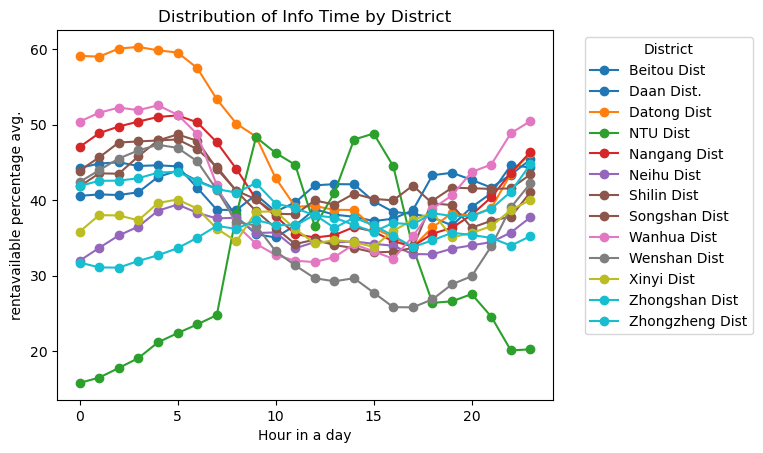

<Figure size 6400x3200 with 0 Axes>

In [9]:

# 按照 'district_en' 和 'info_time' 聚合
grouped = groupByHourAndDistrict['ratio'].mean().unstack()

colors = plt.cm.get_cmap('tab10', len(grouped.columns))

for i,area in enumerate(grouped.columns):
    plt.plot(grouped.index, grouped[area], marker='o', label=area, color=colors(i))

plt.title('Distribution of Info Time by District')
plt.xlabel('Hour in a day')
plt.ylabel('rentavailable percentage avg.')
plt.legend(title='District', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.figure(figsize=(64, 32))
plt.show()

### Inspecting the distribution of the total number of parking lots

- Using a histogram, find out the mode of the total number of parking lots.
- Using boxplots, identify the quartiles of the total number of parking lots.

1408


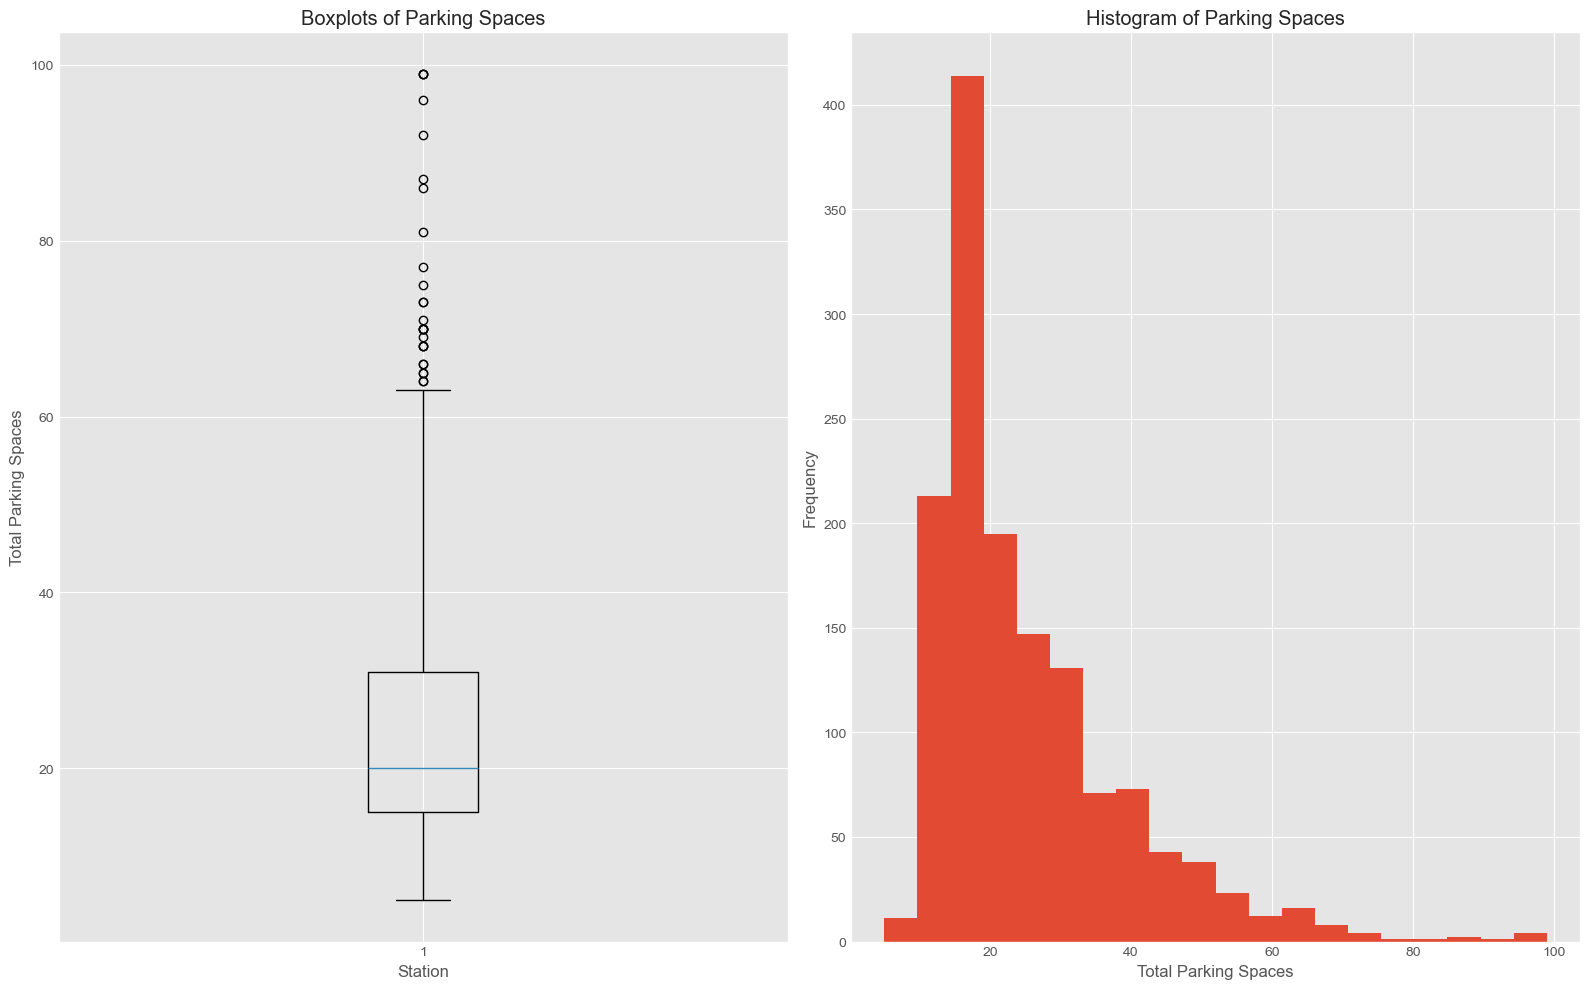

In [19]:
groupByStation = bikecsv.groupby(['station_name_en'], as_index=False)

dataframe = groupByStation['total'].max().sort_values(by='total',ascending=True)

parkinglots = dataframe['total']
print(len(parkinglots))

plt.style.use('ggplot')
fig = plt.figure('Parking distribution',figsize=(16,10))
# 創建並排的子圖
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

ax1.boxplot(parkinglots,whis=2)
ax1.set_title('Boxplots of Parking Spaces')
ax1.set_xlabel('Station')
ax1.set_ylabel('Total Parking Spaces')

ax2.hist(parkinglots, bins=20)
ax2.set_title('Histogram of Parking Spaces')
ax2.set_xlabel('Total Parking Spaces')
ax2.set_ylabel('Frequency')


plt.tight_layout()
plt.show()

**According to the boxplots and histogram, the total number of parking spaces is a determining factor in the distribution.**

These visualizations illustrate that most stations have 15 parking lots. Additionally, we could divide the stations into four sections to inspect the differences in average usage rates.

In [11]:
parkinglots.describe()

count    1408.00000
mean       24.99929
            ...    
75%        31.00000
max        99.00000
Name: total, Length: 8, dtype: float64

`parkinglots.describe()` provides statistical insights, including quartiles and the standard deviation of parking spaces at each station.

In the following code, we will use the `cut` method built into Pandas to label the range from the 1st quartile to the 3rd quartile, including outliers.

Furthermore, we will inspect bike renting ratios with total parking lots in quartiles and outliers.

In [12]:
qtrBikecsv = filtered.copy()
# get cut bins based on descriptions of parkinglots 
qcuts = pd.cut(qtrBikecsv['total'], bins=[0,15,20,30,60,99], labels=['Q1','Q2','Q3','Q4','Outlier'])

qtrBikecsv = pd.concat((qtrBikecsv, qcuts.rename('range')),axis=1)

qtrBikecsv


<class 'pandas.core.frame.DataFrame'>
Index: 707282 entries, 0 to 814261
Data columns (total 11 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   station_name_en  707282 non-null  object        
 1   district_en      707282 non-null  object        
 2   total            707282 non-null  int64         
 3   rentAvailable    707282 non-null  int64         
 4   returnAvaiable   707282 non-null  int64         
 5   updated_time     707282 non-null  datetime64[ns]
 6   info_time        707282 non-null  datetime64[ns]
 7   TimeDiff         707282 non-null  float64       
 8   isWorkDay        707282 non-null  bool          
 9   ratio            707282 non-null  float64       
 10  range            707282 non-null  category      
dtypes: bool(1), category(1), datetime64[ns](2), float64(2), int64(3), object(2)
memory usage: 55.3+ MB

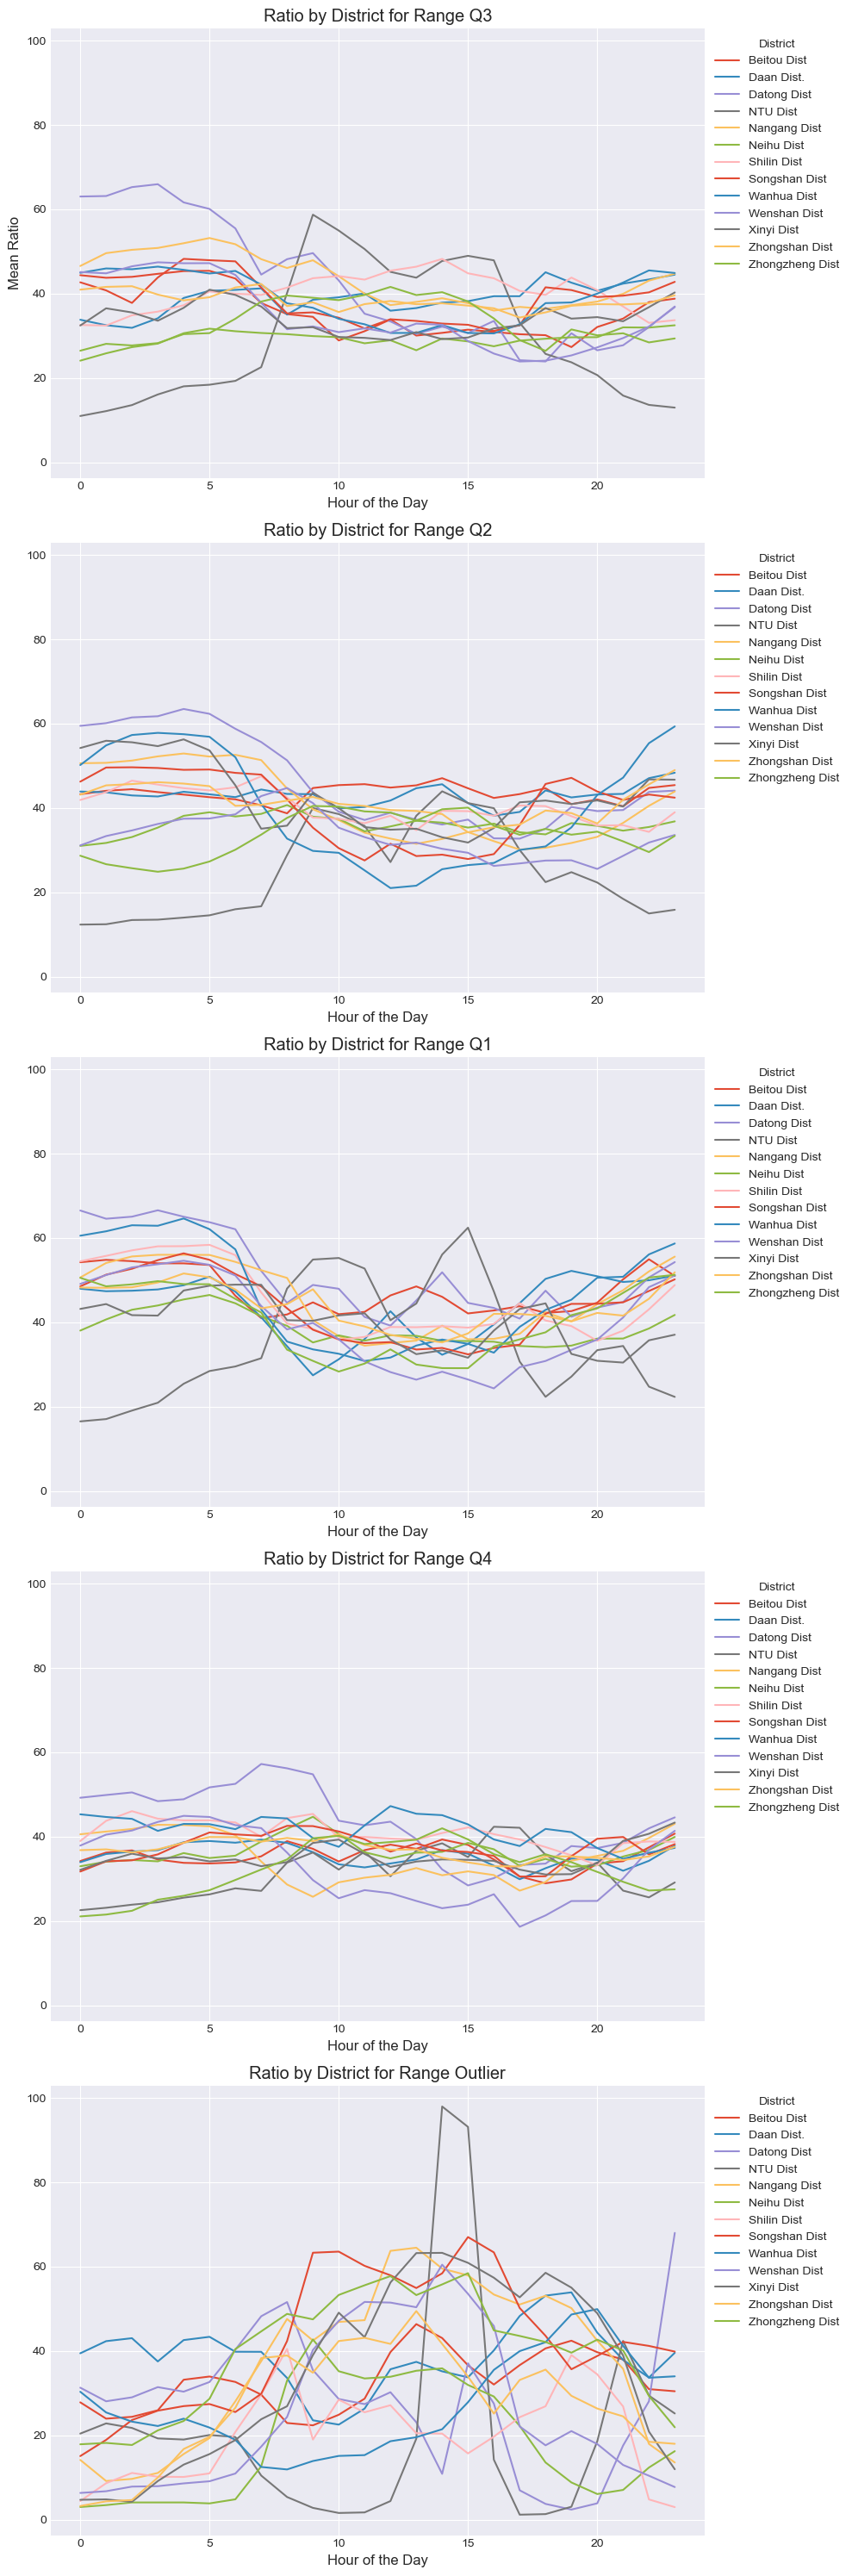

In [13]:
# 使用 matplotlib 庫設置圖表樣式
plt.style.use('seaborn-v0_8-darkgrid')

# 獲取 'range' 列的唯一值
uniq_ranges = qtrBikecsv['range'].unique()

# 設置子圖的行列數
num_rows = len(uniq_ranges)
num_cols = 1  # 一列只有一張圖表

# 創建子圖
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6*num_rows),sharey=True)

# 逐個處理每個唯一值
for i, uniq in enumerate(uniq_ranges):
    # 根據 'range' 分組
    groupQtrDist = qtrBikecsv.loc[qtrBikecsv['range'] == uniq, :].groupby([ qtrBikecsv['info_time'].dt.hour,'district_en'])
        
    # 計算每個分組的平均值，並將 'info_time' 時間的層次解除堆疊
    pivot_table = groupQtrDist['ratio'].mean().unstack()
    # 繪製折線圖
    pivot_table.plot(kind='line', ax=axes[i])
    
    # 設置圖表標題和軸標籤
    axes[i].set_title(f'Ratio by District for Range {uniq}')
    axes[i].set_xlabel('Hour of the Day')
    axes[i].set_ylabel('Mean Ratio' if i == 0 else "")  # 只在第一個子圖上顯示 Y 軸標籤        
    # 設置圖例
    axes[i].legend(title='District', bbox_to_anchor=(1, 1))

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()

The comparison among outliers and other charts shows that the changes in average renting ratios are drastic. 

This indicates that renting ratios by hour will impact linear regression models. 

Thus, we need to remove outliers from the datasets before creating a linear model.